---

In [1]:
%cd ../../../..

/home/k.rooijers/Projects/OOPS_2023


/home/k.rooijers/.cache/pypoetry/virtualenvs/oops-2023-mKfZaHlF-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd

In [3]:
import xarray

In [4]:
import numpy as np

In [5]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn

---

### Load data

In [6]:
from pathlib import Path

In [7]:
OUTDIR = Path("pipeline_activation/")

Samplesheet:

In [8]:
sample_subset = pd.read_csv(OUTDIR / "samplesheet.tsv", sep="\t")

In [9]:
assert type(sample_subset.index) is pd.core.indexes.range.RangeIndex

In [10]:
assert (sample_subset.groupby(['batch', 'library_type', 'crosslinked', 'activated']).size() == 3).all()

Intensity values:

In [11]:
intensities = pd.read_csv(OUTDIR / "intensity-values.tsv", sep="\t")

In [12]:
Y = intensities[[col for col in sample_subset['sample_label']]].values

In [13]:
assert (Y <= np.finfo("float32").max).all()

In [14]:
# log-transform
with np.errstate(divide='ignore', invalid='ignore'):
    Yl = np.log10(np.ma.masked_less_equal(Y, 0.))

In [15]:
w_valid = intensities[['hgnc_ids', 'w_valid']].set_index('hgnc_ids')['w_valid']

w_valid.sum()

5561

Normalize using median correction:

In [16]:
log_intensity_medians = pd.read_csv(
    OUTDIR / "model-output/log_intensity_medians.tsv",
    sep="\t", index_col=0,
).iloc[:, 0].values

In [17]:
Yln = Yl - (1 / np.log(10) * log_intensity_medians)

In [18]:
Yln.shape

(7531, 24)

In [19]:
Yln = xarray.DataArray(
    Yln,
    dims=("gene", "sample"),
    coords={
        "gene": intensities["hgnc_ids"].values,
        "sample": sample_subset["sample_label"]
    }
)

Calculate logFCs:

In [20]:
grouping = sample_subset.groupby(['library_type', 'activated']).groups

In [21]:
Yln.shape

(7531, 24)

In [22]:
lfcs = np.ma.masked_invalid(
    Yln.isel(sample=grouping[('fullproteome', 'yes')]).values.mean(axis=1)
    - Yln.isel(sample=grouping[('fullproteome', 'no')]).values.mean(axis=1)
)

lfcs.shape

(7531,)

Load MAP:

In [23]:
map_ds = xarray.load_dataset(OUTDIR / "model-output/global_map.h5")

E = xarray.concat(
    [map_ds['E'], map_ds['Ederiv'].rename({"deriv_coef": "coef"})],
    dim='coef',
)

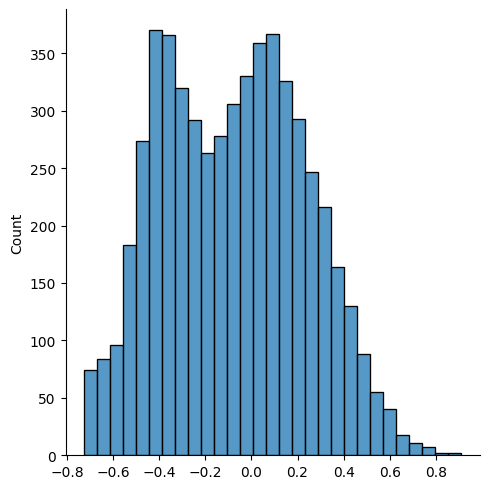

In [24]:
seaborn.displot(E.sel(coef='Intercept'))

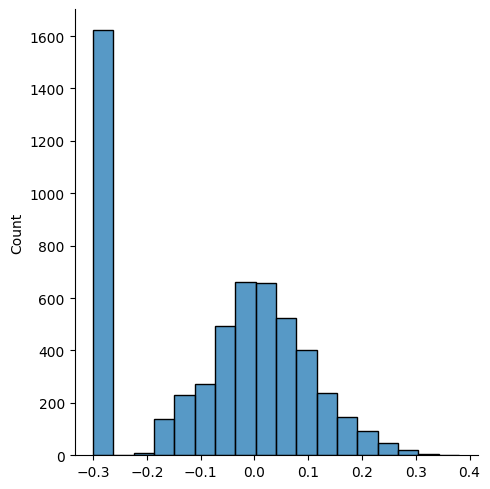

In [25]:
seaborn.displot(E.sel(coef='OOPS_abundance'))

In [26]:
w_expr = (
    (E.sel(coef='Intercept') >= -0.75)
#     & (E.sel(coef='OOPS_abundance') >= -0.25)
)
assert w_expr.mean().item() >= 0.6

w_expr.mean()

<xarray.DataArray 'E' ()> Size: 8B
array(1.)
Coordinates:
    coef     <U34 136B 'Intercept'

In [27]:
E.shape

(5561, 15)

Text(0.95, 0.95, '$\\rho = 1.00$')

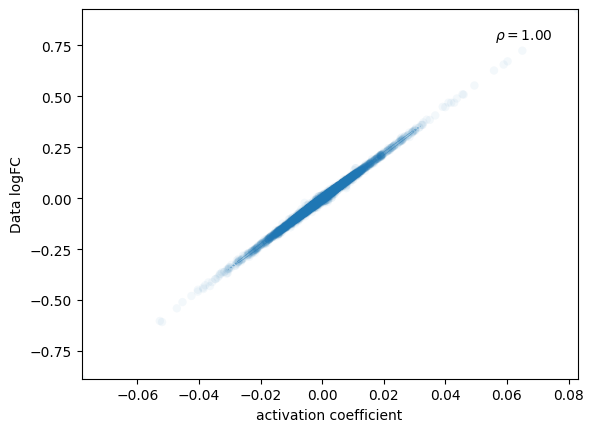

In [28]:
fig, ax = plt.subplots(1, 1)

ax.scatter(
    E.sel(coef='activation_FP'),
    lfcs[w_valid].filled(np.nan),
    lw=0., edgecolor='none',
    alpha=0.05,
)

seaborn.kdeplot(
    x=E.sel(coef='activation_FP').values,
    y=lfcs[w_valid].filled(np.nan),
    fill=False, levels=8,
    cut=0.,
    ax=ax,
    linewidths=0.25,
)

ax.set_xlabel("activation coefficient");
ax.set_ylabel("Data logFC");

ax.text(
    0.95, 0.95,
    r"$\rho = %.2f$" % np.corrcoef(
        E.sel(coef='activation_FP').values[~lfcs[w_valid].mask],
        lfcs[w_valid].compressed(),
    )[0, 1],
    ha="right", va="top",
    transform=ax.transAxes,
)

---

### DEP workflow data

In [29]:
!ls pipeline_activation/figures/*tsv

pipeline_activation/figures/dep_workflow.diff_expr.activation.tsv


In [30]:
dep_tbl = pd.read_table(OUTDIR / "figures/dep_workflow.diff_expr.activation.tsv")

In [31]:
dep_tbl.head()

,name,ID,fullproteome_actno_vs_fullproteome_actyes_p.val,fullproteome_actno_vs_fullproteome_actyes_p.adj,significant,fullproteome_actno_vs_fullproteome_actyes_significant,fullproteome_actno_vs_fullproteome_actyes_ratio,fullproteome_actno_centered,fullproteome_actyes_centered,OOPS_actno_centered,OOPS_actyes_centered,fdr
1,ABCB10,HGNC:41,0.117919,0.03180,True,True,-0.797,0.407,1.200,-0.552,-1.060,0.999973
2,ACO1,HGNC:117,0.058641,0.00392,True,True,0.914,1.870,0.952,-1.280,-1.540,0.999973
3,ACYP1,HGNC:179,0.068147,0.00639,True,True,0.909,1.900,0.989,-1.440,-1.440,0.999973
4,AFDN,HGNC:7137,0.107478,0.02440,True,True,0.976,2.700,1.720,-2.260,-2.150,0.999973
5,AGAP2,HGNC:16921,0.039531,0.00114,True,True,-1.360,0.328,1.690,-1.480,-0.544,0.999973


In [32]:
dep_ratio = dep_tbl.set_index("ID")["fullproteome_actno_vs_fullproteome_actyes_ratio"]

In [33]:
dep_ratio.name

'fullproteome_actno_vs_fullproteome_actyes_ratio'

NB: -1 * DEP ratio because it compares no vs yes

In [34]:
t = pd.merge(
    E.sel(coef="activation_FP").to_pandas().rename("activation_FP"),
    -1 * dep_ratio.rename("dep_ratio"),
    left_index=True, right_index=True,
)

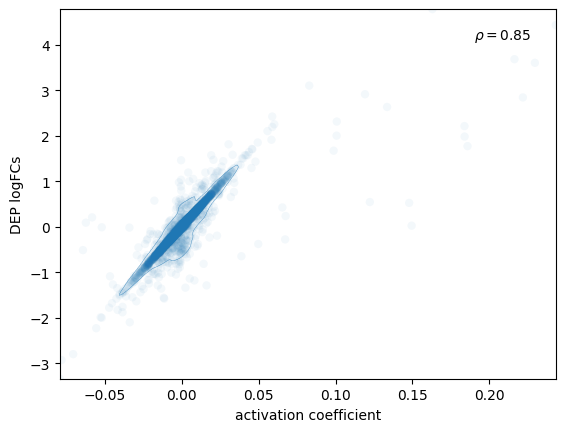

In [35]:
fig, ax = plt.subplots(1, 1)

sca = ax.scatter(
    t['activation_FP'],
    t['dep_ratio'],
    lw=0., edgecolor='none',
    alpha=0.05,
)
sca.set_rasterized(True)

seaborn.kdeplot(
    x=t['activation_FP'].values,
    y=t['dep_ratio'],
    fill=False, levels=8,
    cut=0.,
    ax=ax,
    linewidths=0.25,
)

ax.set_xlabel("activation coefficient");
ax.set_ylabel("DEP logFCs");

ax.text(
    0.95, 0.95,
    r"$\rho = %.2f$" % np.corrcoef(
        t['activation_FP'],
        t['dep_ratio'],
    )[0, 1],
    ha="right", va="top",
    transform=ax.transAxes,
)

fig.savefig(OUTDIR / "figures/scatter_correlation_activation_logfcs_dep_and_activation_coef.pdf")

---

---

---